## Hipótesis 4: Sobre el Poder Predictivo del Machine Learning 

- **Hipótesis Nula (H₀)**: Un modelo de Machine Learning, usando los indicadores como características, no es capaz de generar una señal de trading que produzca un rendimiento superior al de la mejor estrategia basada en reglas que encontramos.


- **Hipótesis Alternativa (H₁)**: Un modelo de Machine Learning sí puede aprender patrones complejos para generar una señal más inteligente, logrando un rendimiento superior y/o un mejor rendimiento ajustado al riesgo que cualquier estrategia de reglas fijas.


**Objetivo del Notebook**

Este notebook tiene como objetivo desarrollar un modelo de Machine Learning capaz de generar señales de compra superiores a la mejor estrategia basada en reglas identificada en el análisis anterior (signal_ichimoku_kijun_cross con un retorno del 181.63%). Se probarán y evaluarán múltiples algoritmos de clasificación para encontrar el modelo con el mejor rendimiento predictivo y, finalmente, se guardará el modelo campeón para su posterior evaluación en un backtest.



 **Interpretación de las Métricas de Evaluación de Modelos**

Para evaluar el rendimiento de nuestros modelos de clasificación, utilizamos un **Informe de Clasificación** estándar, que proporciona varias métricas clave.  
Dado que nuestro objetivo es generar señales de compra fiables, nos centramos principalmente en el rendimiento del modelo para la **clase 1** (que representa una oportunidad de compra exitosa).

---

 **Métricas Principales (Clase 1)**

Estas métricas evalúan la capacidad del modelo para identificar correctamente las oportunidades de inversión.

**Precision** (Precisión)
- **Pregunta que responde:**  
  De todas las veces que el modelo predijo "**¡Compra!**", ¿qué porcentaje de veces acertó?

- **Relevancia en el Proyecto:**  
  Es la métrica más importante. Una alta precisión es crucial para una estrategia de trading, ya que minimiza el capital desperdiciado en falsas alarmas y operaciones perdedoras.

**Recall (Sensibilidad)**
- **Pregunta que responde:**  
  De todas las oportunidades de compra reales que hubo, ¿cuántas fue capaz de encontrar el modelo?

- **Relevancia en el Proyecto:**  
  Mide la capacidad del modelo para no perderse ganancias potenciales.  
  Existe un *trade-off* inherente entre la **Precisión** y el **Recall**.

**F1-Score**
- **Pregunta que responde:**  
  ¿Cuál es el equilibrio armónico entre la **Precisión** y el **Recall**?

- **Relevancia en el Proyecto:**  
  Es una métrica global útil para comparar modelos que tienen diferentes equilibrios de Precisión/Recall.

 **Support**
- **Qué significa:**  
  Es simplemente el número total de ejemplos reales de esa clase en el conjunto de datos de prueba.

---

**Métricas Globales**

 **Accuracy (Exactitud)**
- **Qué significa:**  
  De todas las predicciones realizadas, ¿qué porcentaje fue correcto?

- **Nota:**  
  Esta métrica puede ser engañosa en datasets desbalanceados como el nuestro.  
  Un modelo inútil que siempre predice "**No Compra**" podría tener una exactitud alta.

 **Macro Avg & Weighted Avg**
- **Qué significan:**  
  Son las medias de las métricas (**Precisión**, **Recall**, **F1**) a través de ambas clases.  
  La **Media Ponderada (Weighted Avg)** es más relevante para nosotros, ya que ajusta el cálculo según el número de ejemplos en cada clase.


### 1. Configuración del Entorno


In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


### 2. Preparación de Datos para Machine Learning
- El éxito de cualquier modelo de ML depende de la calidad de los datos con los que se entrena. 
- En esta fase, definiremos el problema a resolver (la variable target), seleccionaremos las características más informativas y prepararemos los datos para el entrenamiento.

#### 2.1. Carga y Enriquecimiento de Datos
- Se carga el dataset pre-procesado del notebook anterior, que ya contiene los indicadores técnicos calculados y el ``target``.
- el target que establecimos fue si el precio subiria un 4% en los proximos 19 dias

In [5]:
df = pd.read_csv('../data/VOO_ind_signal.csv',parse_dates=['date'])

In [6]:
df.head()

,date,close,high,low,open,volume,daily_return,rsi,macd,macd_signal,...,retorno_futuro,target,body_size,upper_wick,lower_wick,rsi_roc_5,month_sin,month_cos,price_vs_kijun,tenkan_vs_kijun
0,2011-06-30,93.761,93.885,93.092,93.186,124850,0.010,59.020,-0.219,-0.626,...,-0.012926,0,0.575,0.124,0.094,32.290312,1.224647e-16,-1.000000,1.405,-0.569
1,2011-07-01,95.175,95.252,93.652,93.807,139550,0.015,64.323,0.067,-0.488,...,-0.035104,0,1.368,0.077,0.155,61.400647,-5.000000e-01,-0.866025,2.819,0.114
2,2011-07-05,95.019,95.252,94.786,95.097,91850,-0.002,63.349,0.277,-0.335,...,-0.036961,0,0.078,0.155,0.233,41.780623,-5.000000e-01,-0.866025,2.663,0.114
3,2011-07-06,95.159,95.283,94.600,94.848,94850,0.001,63.877,0.450,-0.178,...,-0.062380,0,0.311,0.124,0.248,24.889045,-5.000000e-01,-0.866025,2.803,0.130
4,2011-07-07,96.200,96.418,95.858,96.014,195400,0.011,67.617,0.664,-0.009,...,-0.067838,0,0.186,0.218,0.156,22.625632,-5.000000e-01,-0.866025,3.324,0.318


- Comprobamo el balance de las clases del target

In [7]:
print(df['target'].value_counts(normalize=True))

target
0    0.813272
1    0.186728
Name: proportion, dtype: float64


#### 2.2. Selección de Características (Feature Selection)
Basado en el análisis de correlación del EDA, se selecciona un subconjunto de características potente y poco redundante. Se incluyen las relaciones numéricas de nuestra estrategia campeona (Ichimoku) para darle al modelo la mejor información posible.


In [8]:
#Definicion de features con diferentes tipos para despues combinarlas. 

features_num = [
    'rsi', 'macd_diff', 'bollinger_width', 'atr', 'adx', 
    'volume_ratio', 'price_vs_kijun', 'tenkan_vs_kijun'
]

features_bool = [
    'signal_ema_price','signal_macd_buy',
    'signal_stochastic_buy','signal_ichimoku_kijun_cross'
]

features_advan = ['body_size','upper_wick','lower_wick','rsi_roc_5',
    'month_sin','month_cos']


- Para el entrenamiendo de diferentes modelos definimos diferentes tipos de features y despues las utilizaremos combianas, con esto lo que queremos averiguar es: 
    1) Cual de ellas tendra mejor rendimiento
    2) ¿ Combinar las features nos da mejor rendimiento? o ¿ proporcionas mas ruido y peores rendimientos?

In [9]:
# Creamos las X e y para las features_num (solamente)
X_num = df[features_num]
y = df['target'] # el traget al ser el mismo solo lo definimos una vez. 

# Creamos las X e y para la combinacion de features_num + features_bol
features_num_bol = features_num + features_bool
X_num_bol = df[features_num_bol]

# Creamos la combinacion de features_num + features_advan
features_num_advan = features_num + features_advan
X_num_advan = df[features_num_advan]

#### 2.4. División y Escalado de Datos
- Se dividen los datos para cada tipo de features. 
- Despues hace el escalado de los datos y guardado en las diferentes carpetas donde guaradaremos los modelos entrenados. 

In [10]:
#Division de los datos

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y, test_size=0.2, shuffle=False)

X_train_num_bol, X_test_num_bol, y_train_num_bol,y_test_num_bol = train_test_split(X_num_bol,y,test_size=0.2,shuffle=False)

X_train_num_advan,X_test_num_advan,y_train_num_advan, y_test_num_advan = train_test_split(X_num_advan,y,test_size=0.2,shuffle=False)

In [11]:
#Escalado para los datos de features_num
scaler_num = StandardScaler()
X_train_scaled_num = scaler_num.fit_transform(X_train_num)
X_test_scaled_num = scaler_num.transform(X_test_num)

with open('../models/models_num/scaler_num.pkl', 'wb') as f:
    pickle.dump(scaler_num, f)


#Escalado para los datos de features_num_bol
scaler_numbol = StandardScaler()
X_train_scaled_numbol = scaler_numbol.fit_transform(X_train_num_bol)
X_test_scaled_numbol = scaler_numbol.transform(X_test_num_bol)


with open('../models/models_numbols/scaler_numbol.pkl', 'wb') as f:
    pickle.dump(scaler_numbol, f)

#Escalado para los datos de features_num_advan
scaler_numadvan = StandardScaler()
X_train_scaled_numadvan = scaler_numadvan.fit_transform(X_train_num_advan)
X_test_scaled_numadvan = scaler_numadvan.transform(X_test_num_advan)


with open('../models/models_numadvan/scaler_numadvan.pkl', 'wb') as f:
    pickle.dump(scaler_numadvan, f)

### 3. Entrenamiento de modelos. (SIN AJUSTE DE HIPERPARAMETROS)

In [22]:
def train_evaluate_models (model, model_name:str, X_train, y_train, X_test, y_test,save_model:bool=False, save_dir : str ='models'):
    
    print(f"Entrenando modelo de : {model_name}")
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    print(f"Informe de Clasisficación:{model_name}")
    print(classification_report(y_test,y_pred))
    
    print(f"Matriz de Confusión de {model_name}")
    ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()
    
    if save_model: 
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            print(f"Carpeta '{save_dir} creada ")
        filepath = os.path.join(save_dir,f'{model_name}.pkl')
        with open(filepath,'wb') as f: 
            pickle.dump(model,f)
        print(f'El modelo se ha guardado con exito')

    return model 

#### 3.1 Entrenamiento de modelos con ``class_weight='balanced'`` 

#### 3.1.1 Regresion logistica

Entrenando modelo de : Regresion_logistica_num
Informe de Clasisficación:Regresion_logistica_num
              precision    recall  f1-score   support

           0       0.83      0.39      0.53       532
           1       0.27      0.74      0.40       165

    accuracy                           0.47       697
   macro avg       0.55      0.57      0.47       697
weighted avg       0.70      0.47      0.50       697

Matriz de Confusión de Regresion_logistica_num


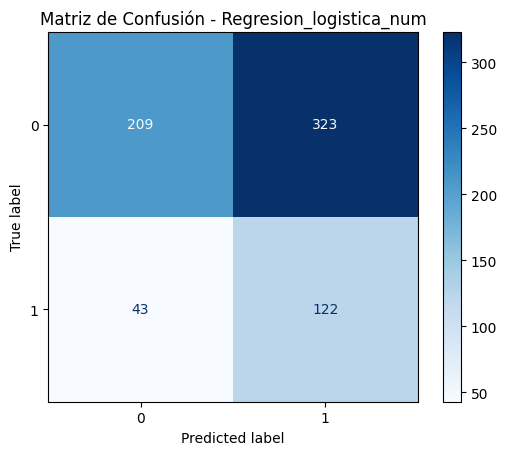

El modelo se ha guardado con exito


In [23]:
log_reg_num = LogisticRegression(random_state=42,class_weight='balanced')
log_reg_num_train = train_evaluate_models(
    model=log_reg_num,
    model_name='Regresion_logistica_num',
    X_train=X_train_num,
    y_train=y_train_num,
    X_test=X_test_num,
    y_test=y_test_num,
    save_model=True,
    save_dir='../models/models_num/'
)

Entrenando modelo de : Regresion_logistica_numbol
Informe de Clasisficación:Regresion_logistica_numbol
              precision    recall  f1-score   support

           0       0.83      0.40      0.54       532
           1       0.28      0.74      0.40       165

    accuracy                           0.48       697
   macro avg       0.55      0.57      0.47       697
weighted avg       0.70      0.48      0.50       697

Matriz de Confusión de Regresion_logistica_numbol


c:\Users\franc\ENTORNO TRABAJO DATA y BI\IRONHACK\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


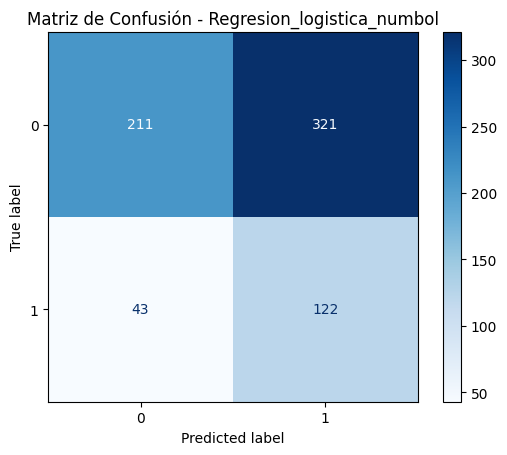

El modelo se ha guardado con exito


In [24]:
log_reg_numbol = LogisticRegression(random_state=42,class_weight='balanced')
log_reg_num_train = train_evaluate_models(
    model=log_reg_numbol,
    model_name='Regresion_logistica_numbol',
    X_train=X_train_num_bol,
    y_train=y_train_num_bol,
    X_test=X_test_num_bol,
    y_test=y_test_num_bol,
    save_model=True,
    save_dir='../models/models_numbols/'
)

#### 3.1.2 Random Forest


In [ ]:
rf_balanced = RandomForestClassifier(
    n_estimators=100,       # 
    random_state=42,
    class_weight='balanced', 
    n_jobs=-1               
)

rf_balanced.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [185]:
y_pred_rf = rf_balanced.predict(X_test_scaled)

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       532
           1       0.33      0.19      0.25       165

    accuracy                           0.72       697
   macro avg       0.56      0.54      0.54       697
weighted avg       0.67      0.72      0.69       697



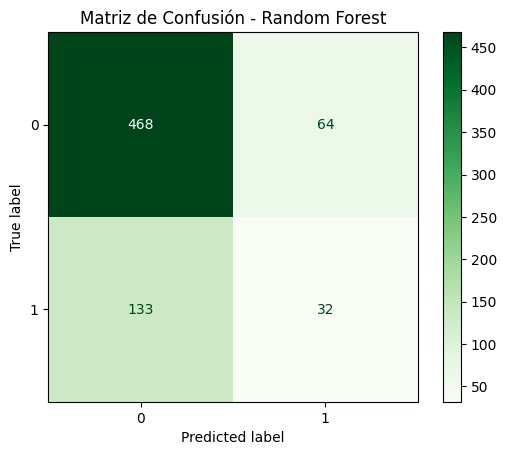

In [186]:
report_rf = classification_report(y_test, y_pred_rf)
print(report_rf)


ConfusionMatrixDisplay.from_estimator(rf_balanced, X_test_scaled, y_test, cmap='Greens')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

In [187]:
with open('../models/RandomForestBal.pkl', 'wb') as f:
    pickle.dump(rf_balanced, f)

#### 3.1.3 Suport Vector Machine (SVM)

In [188]:
svm_model = SVC(
    probability=True,       
    random_state=42,
    class_weight='balanced' 
)
svm_model.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [189]:
y_pred_svm = svm_model.predict(X_test_scaled)

Informe de Clasificación
              precision    recall  f1-score   support

           0       0.79      0.49      0.60       532
           1       0.26      0.58      0.36       165

    accuracy                           0.51       697
   macro avg       0.53      0.54      0.48       697
weighted avg       0.66      0.51      0.55       697



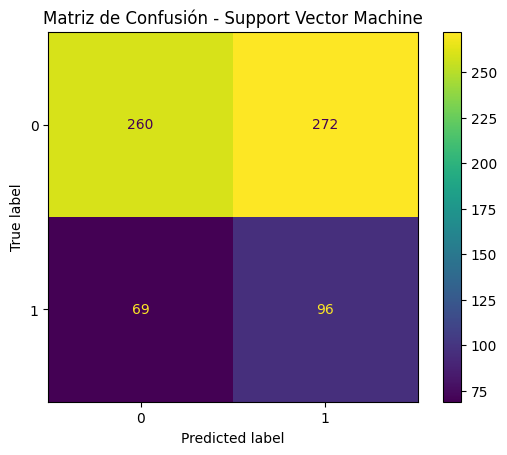

In [196]:
print("Informe de Clasificación")
print(classification_report(y_test, y_pred_svm))

ConfusionMatrixDisplay.from_estimator(svm_model, X_test_scaled, y_test, cmap='viridis')
plt.title('Matriz de Confusión - Support Vector Machine')
plt.show()

#### 3.2 Entrenamiento de modelos con ``SMOTE`` 

#### 3.2.1 GRADIEN BOOSTING


In [192]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Balance de clases antes de SMOTE:", y_train.value_counts(normalize=True))
print("Balance de clases después de SMOTE:", y_train_resampled.value_counts(normalize=True))

Balance de clases antes de SMOTE: target
0    0.82579
1    0.17421
Name: proportion, dtype: float64
Balance de clases después de SMOTE: target
0    0.5
1    0.5
Name: proportion, dtype: float64


In [193]:
gb_model = GradientBoostingClassifier(
    n_estimators=100,       
    random_state=42,
    learning_rate=0.1,
    max_depth=3
)
gb_model.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(random_state=42)

In [194]:
y_pred_gb = gb_model.predict(X_test_scaled)

Informe de Clasificación
              precision    recall  f1-score   support

           0       0.81      0.60      0.69       532
           1       0.30      0.55      0.38       165

    accuracy                           0.59       697
   macro avg       0.55      0.57      0.54       697
weighted avg       0.69      0.59      0.62       697



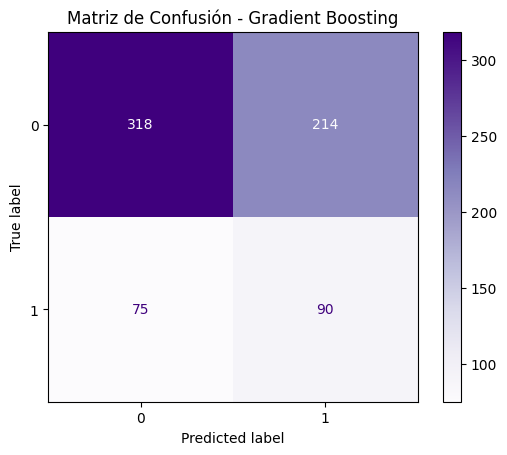

In [195]:
print("Informe de Clasificación")
report_gb = classification_report(y_test, y_pred_gb)
print(report_gb)

ConfusionMatrixDisplay.from_estimator(gb_model, X_test_scaled, y_test, cmap='Purples')
plt.title('Matriz de Confusión - Gradient Boosting')
plt.show()


#### 3.2.2 XGBOOST

Informe de Clasificación 
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       532
           1       0.35      0.44      0.39       165

    accuracy                           0.67       697
   macro avg       0.58      0.59      0.58       697
weighted avg       0.70      0.67      0.68       697



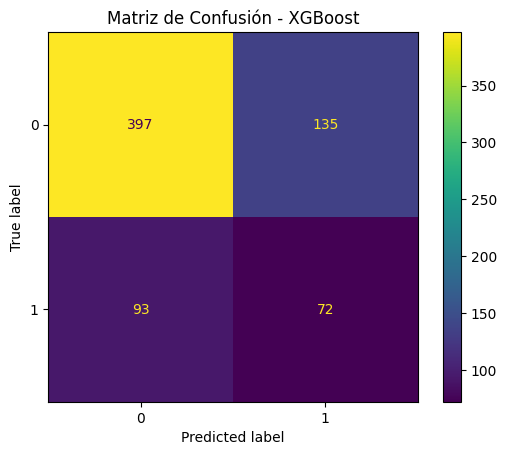

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=100,
    random_state=42, 
    eval_metric='logloss',  
    n_jobs=-1
)

xgb_model.fit(X_train_resampled, y_train_resampled)


y_pred_xgb = xgb_model.predict(X_test_scaled)

print("Informe de Clasificación ")
print(classification_report(y_test, y_pred_xgb))

ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_scaled, y_test, cmap='viridis')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

#### 3.2.3 Naive Bayes

In [200]:
gnb_model = GaussianNB()
gnb_model.fit(X_train_resampled, y_train_resampled)


y_pred_gnb = gnb_model.predict(X_test_scaled)



Informe de Clasificación 
              precision    recall  f1-score   support

           0       0.82      0.27      0.41       532
           1       0.26      0.81      0.39       165

    accuracy                           0.40       697
   macro avg       0.54      0.54      0.40       697
weighted avg       0.69      0.40      0.40       697



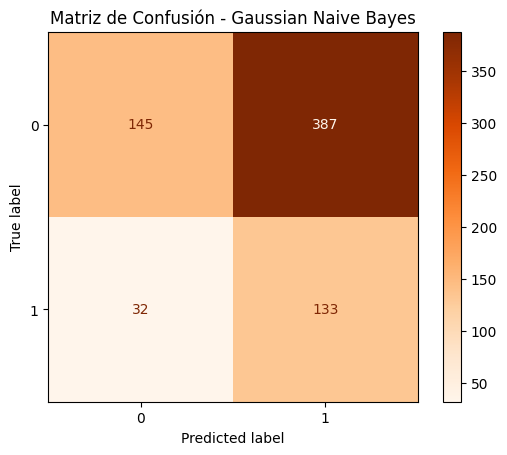

In [201]:
print("Informe de Clasificación ")
print(classification_report(y_test, y_pred_gnb))

ConfusionMatrixDisplay.from_estimator(gnb_model, X_test_scaled, y_test, cmap='Oranges')
plt.title('Matriz de Confusión - Gaussian Naive Bayes')
plt.show()

#### 3.3 Modelo de DeepLearning: MLP Classifier

In [202]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(500, 250), 
    random_state=42,
    max_iter=1000, 
    activation='relu'
)

mlp_model.fit(X_train_resampled, y_train_resampled)

y_pred_mlp = mlp_model.predict(X_test_scaled)



Informe de Clasificación 
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       532
           1       0.27      0.22      0.24       165

    accuracy                           0.68       697
   macro avg       0.52      0.52      0.52       697
weighted avg       0.65      0.68      0.66       697



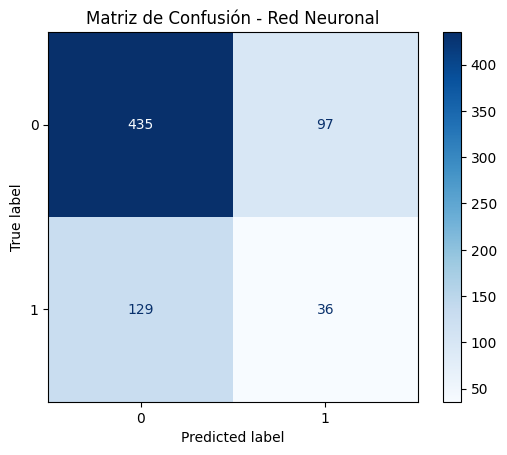

In [203]:
print("Informe de Clasificación ")
print(classification_report(y_test, y_pred_mlp))

ConfusionMatrixDisplay.from_estimator(mlp_model, X_test_scaled, y_test, cmap='Blues')
plt.title('Matriz de Confusión - Red Neuronal')
plt.show()

### 4. Reentrenamiento de los modelos con Features numericas solamente y las que se crearon avanzadas.

In [ ]:
features_advanced = [
    'rsi','macd_diff','bollinger_width', 
    'atr','adx','volume_ratio', 
    'price_vs_kijun','tenkan_vs_kijun',
# Nuevas características numéricas avanzadas
    'body_size','upper_wick','lower_wick','rsi_roc_5',
    'month_sin','month_cos'
]

X_final = df[features_advanced]
y_final = df['target']

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X_final,y_final,test_size=0.2,shuffle=False)

In [208]:
scaler = StandardScaler()
X_train_scaled_adv = scaler.fit_transform(X_train)

In [209]:
X_test_scaled_adv = scaler.transform(X_test)

#### class_weight = balanced

#### 4.1 Logistic Regression

In [211]:
log_reg_balanced = LogisticRegression(
    random_state=42,
    class_weight='balanced' 
)

log_reg_balanced.fit(X_train_scaled_adv, y_train)


LogisticRegression(class_weight='balanced', random_state=42)

In [212]:
y_pred = log_reg_balanced.predict(X_test_scaled_adv)


 Informe de Clasificación 
              precision    recall  f1-score   support

           0       0.82      0.43      0.56       512
           1       0.29      0.72      0.42       169

    accuracy                           0.50       681
   macro avg       0.56      0.57      0.49       681
weighted avg       0.69      0.50      0.53       681



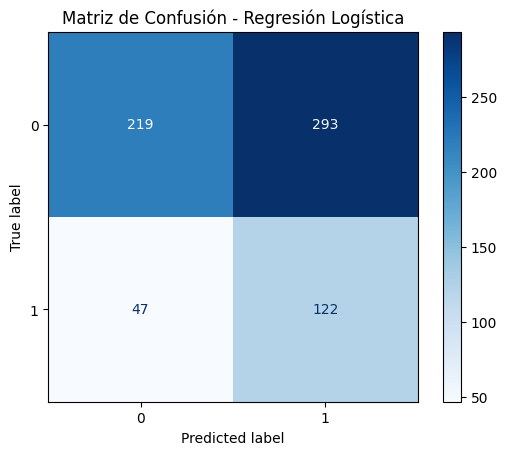

In [220]:
print("\n Informe de Clasificación ")

report = classification_report(y_test, y_pred)
print(report)

ConfusionMatrixDisplay.from_estimator(log_reg_balanced, X_test_scaled_adv, y_test, cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

#### 4.2 Random forest

In [ ]:
rf_balanced = RandomForestClassifier(
    n_estimators=100,       # 
    random_state=42,
    class_weight='balanced', 
    n_jobs=-1               
)

rf_balanced.fit(X_train_scaled_adv, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [216]:
y_pred_rf = rf_balanced.predict(X_test_scaled_adv)

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       512
           1       0.37      0.18      0.25       169

    accuracy                           0.72       681
   macro avg       0.57      0.54      0.54       681
weighted avg       0.67      0.72      0.68       681



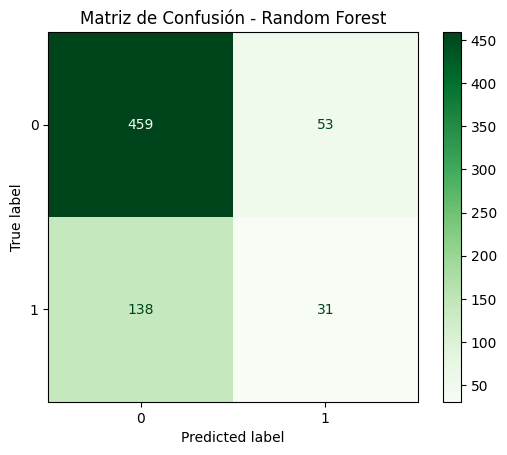

In [ ]:
report_rf = classification_report(y_test, y_pred_rf)
print(report_rf)


ConfusionMatrixDisplay.from_estimator(rf_balanced, X_test_scaled_adv, y_test, cmap='Greens')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

#### 4.3 Suport Vector Machine (SVM)

In [218]:
svm_model = SVC(
    probability=True,       
    random_state=42,
    class_weight='balanced' 
)
svm_model.fit(X_train_scaled_adv, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [219]:
y_pred_svm = svm_model.predict(X_test_scaled_adv)

Informe de Clasificación
              precision    recall  f1-score   support

           0       0.81      0.52      0.64       512
           1       0.30      0.63      0.41       169

    accuracy                           0.55       681
   macro avg       0.56      0.58      0.52       681
weighted avg       0.68      0.55      0.58       681



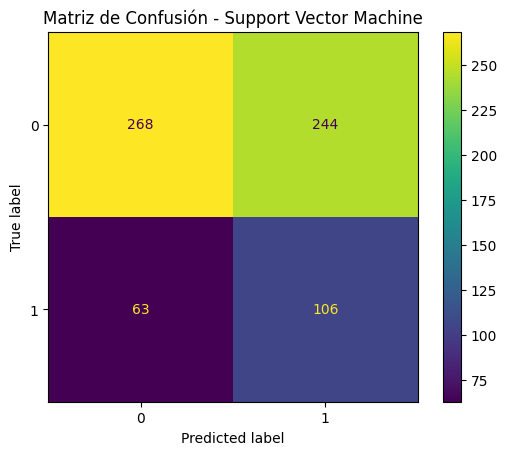

In [221]:
print("Informe de Clasificación")
print(classification_report(y_test, y_pred_svm))

ConfusionMatrixDisplay.from_estimator(svm_model, X_test_scaled_adv, y_test, cmap='viridis')
plt.title('Matriz de Confusión - Support Vector Machine')
plt.show()

#### Rebalanceo con smote

In [227]:
smote_adv = SMOTE(random_state=42)
X_train_resamp_adv, y_train_resamp_adv = smote_adv.fit_resample(X_train_scaled_adv, y_train)

#### 4.4 Gradient Boosting

In [228]:
gb_model_final = GradientBoostingClassifier(
    n_estimators=100,       
    random_state=42,
    learning_rate=0.1,
    max_depth=3
)
gb_model_final.fit(X_train_resamp_adv, y_train_resamp_adv)

GradientBoostingClassifier(random_state=42)

In [229]:
y_pred_gb = gb_model_final.predict(X_test_scaled_adv)

              precision    recall  f1-score   support

           0       0.83      0.60      0.70       512
           1       0.34      0.62      0.44       169

    accuracy                           0.60       681
   macro avg       0.58      0.61      0.57       681
weighted avg       0.71      0.60      0.63       681



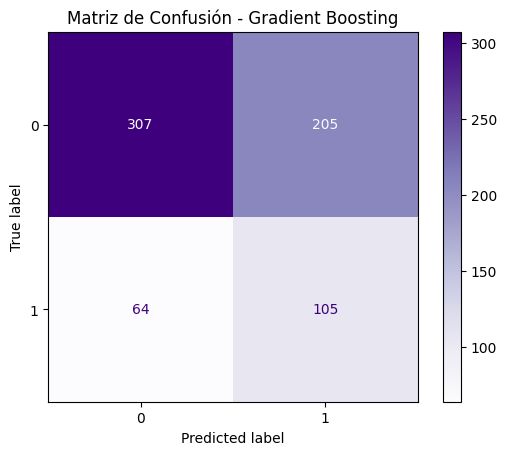

In [230]:
report_gb = classification_report(y_test, y_pred_gb)
print(report_gb)

ConfusionMatrixDisplay.from_estimator(gb_model_final, X_test_scaled_adv, y_test, cmap='Purples')
plt.title('Matriz de Confusión - Gradient Boosting')
plt.show()

#### 4.5 XGBOOST

In [233]:
xgb_adv = XGBClassifier(
    n_estimators=100,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)
xgb_adv.fit(X_train_resamp_adv, y_train_resamp_adv)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, ...)

In [234]:
y_pred_xgb_adv = xgb_adv.predict(X_test_scaled_adv)

Informe de Clasificación (Modelo Final - XGBoost)
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       512
           1       0.39      0.50      0.44       169

    accuracy                           0.68       681
   macro avg       0.60      0.62      0.61       681
weighted avg       0.71      0.68      0.69       681



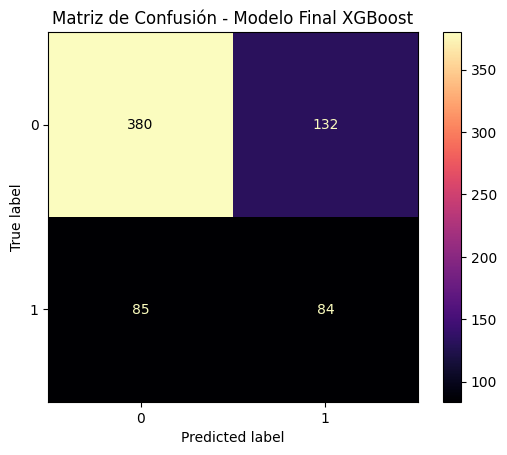

In [237]:
print("Informe de Clasificación (Modelo Final - XGBoost)")
print(classification_report(y_test, y_pred_xgb_adv))

ConfusionMatrixDisplay.from_estimator(xgb_adv, X_test_scaled_adv, y_test, cmap='magma')
plt.title('Matriz de Confusión - Modelo Final XGBoost')
plt.show()

### 5. Ajuste de Hiper parametros


- Para el ajuste de hiper parametros se selecciona Random Forest y XGboost ya que han sido los que mejor resultado dan. 

#### 5.1 Ajuste de hiperparametros en Random Forest. 

In [247]:
param_Hiper_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.5],
    'class_weight': ['balanced']
}

In [248]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [249]:
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_Hiper_rf,
    n_iter=50,  
    cv=5,
    scoring='precision', 
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [250]:
random_search_rf.fit(X_train_scaled_adv, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [5, 7, 10, 15],
                                        'max_features': ['sqrt', 0.5],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='precision', verbose=2)

In [251]:
y_pred_best_rf = random_search_rf.best_estimator_.predict(X_test_scaled_adv)

In [252]:
print(random_search_rf.best_params_)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': 'balanced'}


In [253]:
print("Informe de Clasificación ajustada Random Forest)")
print(classification_report(y_test, y_pred_best_rf))


Informe de Clasificación ajustada Random Forest)
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       512
           1       0.38      0.26      0.31       169

    accuracy                           0.71       681
   macro avg       0.58      0.56      0.56       681
weighted avg       0.68      0.71      0.69       681



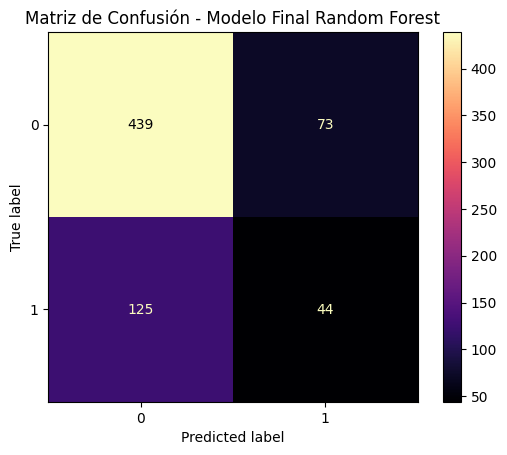

In [255]:
ConfusionMatrixDisplay.from_estimator(random_search_rf, X_test_scaled_adv, y_test, cmap='magma')
plt.title('Matriz de Confusión - Modelo Final Random Forest')
plt.show()

XGBOOST

In [259]:
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}


In [ ]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)


random_search_xgb = (
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=100,
    cv=5,
    scoring=['precision', 'recall', 'f1'],
    n_jobs=-1,
    verbose=2,
    random_state=42
)


random_search_xgb.fit(X_train_resamp_adv, y_train_resamp_adv)


print("\n--- Búsqueda para XGBoost completada ---")
print("Mejores parámetros encontrados:")
print(random_search_xgb.best_params_)

best_xgb_model = random_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test_scaled_adv)

print("\n--- Informe de Clasificación (XGBoost OPTIMIZADO) ---")
print(classification_report(y_test, y_pred_best_xgb))

TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'param_distributions'